完成：3 条子路径采样，已保存 f:\大四上作业文件\制造工程训练\项目代码\x_sampled.json
438


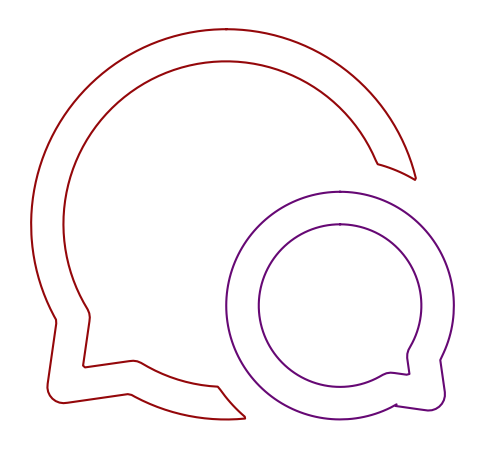

In [9]:
import os
import json
import math
import numpy as np
import xml.etree.ElementTree as ET
from svgpathtools import parse_path
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

def read_viewbox(svg_path):
    root = ET.parse(svg_path).getroot()
    vb = root.get('viewBox') or root.get('viewbox')
    if vb:
        vals = list(map(float, vb.strip().split()))
        return tuple(vals)  # x,y,w,h
    w = float(root.get('width', '1024'))
    h = float(root.get('height', '1024'))
    return (0.0, 0.0, w, h)

def split_path_into_subpaths(path_obj, tol=1e-6):
    """把 svgpathtools.Path 拆成连续的子 Path 列表"""
    segs = list(path_obj)
    if not segs:
        return []
    subs = []
    cur = [segs[0]]
    prev_end = segs[0].end
    for s in segs[1:]:
        if abs(s.start.real - prev_end.real) > tol or abs(s.start.imag - prev_end.imag) > tol:
            subs.append(parse_path(''.join([seg.d() for seg in cur])) if hasattr(cur[0], 'd') else type(path_obj)(*cur))
            cur = [s]
        else:
            cur.append(s)
        prev_end = s.end
    if cur:
        subs.append(type(path_obj)(*cur))
    return subs

def sample_path_by_arclen(path_obj, step=15.0):
    L = path_obj.length(error=1e-5)
    if L <= 1e-9:
        p = path_obj.point(0)
        return [[float(p.real), float(p.imag)]]
    n = max(2, int(math.ceil(L/step)) + 1)
    dense_n = max(500, 5 * n)
    ts = np.linspace(0.0, 1.0, dense_n)
    pts = np.array([path_obj.point(t) for t in ts], dtype=complex)
    xs = pts.real
    ys = pts.imag
    segd = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)
    cum = np.concatenate(([0.0], np.cumsum(segd)))
    samp_d = np.linspace(0.0, cum[-1], n)
    xs_s = np.interp(samp_d, cum, xs)
    ys_s = np.interp(samp_d, cum, ys)
    return [[float(x), float(y)] for x, y in zip(xs_s, ys_s)]

def process_svg(svg_path, sample_step=8.0, out_json=None):
    if out_json is None:
        out_json = os.path.splitext(svg_path)[0] + "_sampled.json"
    tree = ET.parse(svg_path)
    root = tree.getroot()
    vb = read_viewbox(svg_path)
    vb_x, vb_y, vb_w, vb_h = vb
    cx = vb_x + vb_w / 2.0
    cy = vb_y + vb_h / 2.0

    results = []
    paths = root.findall('.//{http://www.w3.org/2000/svg}path') or root.findall('.//path')
    for i, path_el in enumerate(paths):
        d = path_el.get('d')
        attrs = {k: path_el.get(k) for k in ('id','fill','stroke','stroke-width')}
        if not d:
            continue
        path_obj = parse_path(d)
        subs = split_path_into_subpaths(path_obj)
        if not subs:
            subs = [path_obj]
        for j, sub in enumerate(subs):
            pts = sample_path_by_arclen(sub, step=sample_step)
            # shift origin to svg center
            pts_centered = [[x - cx, y - cy] for x,y in pts]
            results.append({
                "orig_path_index": i,
                "subpath_index": j,
                "attrs": attrs,
                "points": pts_centered
            })
    with open(out_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"完成：{len(results)} 条子路径采样，已保存 {out_json}")
    return results

def svg_color_to_rgb(col):
    if not col:
        return (0.0, 0.0, 0.0)
    col = col.strip()
    # matplotlib.to_rgb 能解析大多数 SVG 颜色 (named, #hex, rgb(...))
    try:
        return to_rgb(col)
    except Exception:
        # 额外容错：去掉 url(...) / p-id 等非颜色字符串
        if col.startswith('#'):
            hexs = col[1:]
            if len(hexs) == 3:
                hexs = ''.join([c*2 for c in hexs])
            try:
                r = int(hexs[0:2],16)/255.0
                g = int(hexs[2:4],16)/255.0
                b = int(hexs[4:6],16)/255.0
                return (r,g,b)
            except Exception:
                return (0.0,0.0,0.0)
        return (0.0,0.0,0.0)

def plot_sampled_paths(results, invert_y=True, aspect_equal=True, show=True, save_path=None, figsize=(6,6)):
    plt.figure(figsize=figsize)
    for entry in results:
        pts = entry.get('points') or []
        if len(pts) < 2:
            continue
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        if invert_y:
            ys = [-y for y in ys]
        attrs = entry.get('attrs', {}) or {}
        color = attrs.get('fill') or attrs.get('stroke') or '#000'
        col = svg_color_to_rgb(color)
        plt.plot(xs, ys, color=col)
    if aspect_equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()

# 调用示例（与本 notebook 里 process_svg 使用相同的 SVG 变量）
if __name__ == "__main__":
    SVG = r"f:\大四上作业文件\制造工程训练\项目代码\x.svg"
    results = process_svg(SVG, sample_step=8.0)  # 已存在的函数，会返回采样结果列表
    print(len(results[0]["points"]))
    plot_sampled_paths(results, save_path=None)